C:\Users\mahnoor\AppData\Local\Temp\ipykernel_11864\4090949229.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  people_data = pd.read_sql(query, conn)
C:\Users\mahnoor\AppData\Local\Temp\ipykernel_11864\4090949229.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vehicle_data = pd.read_sql(query, conn)


SystemExit: 0

C:\Users\mahnoor\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


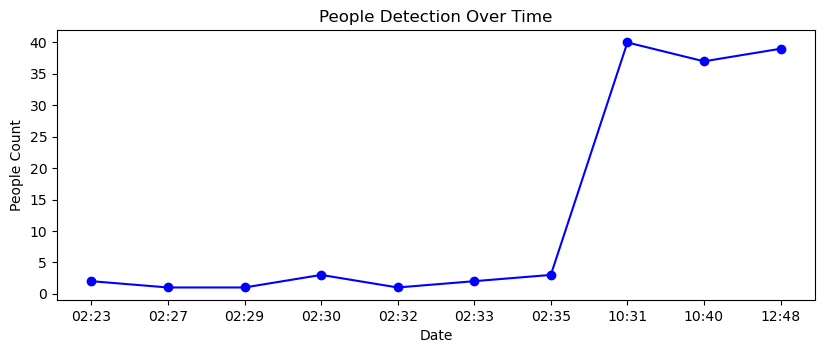

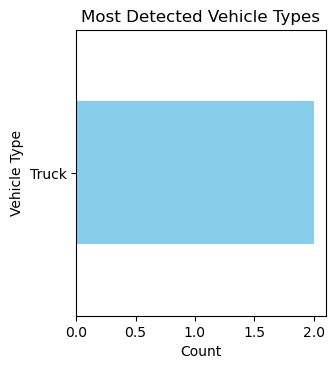

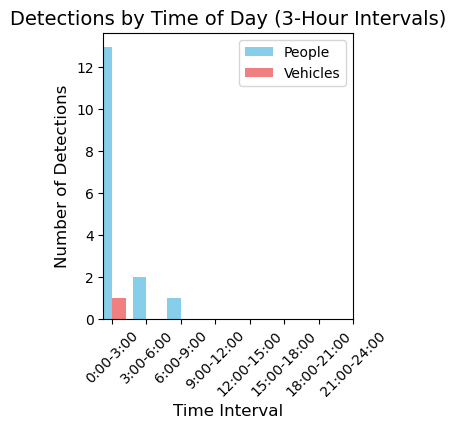

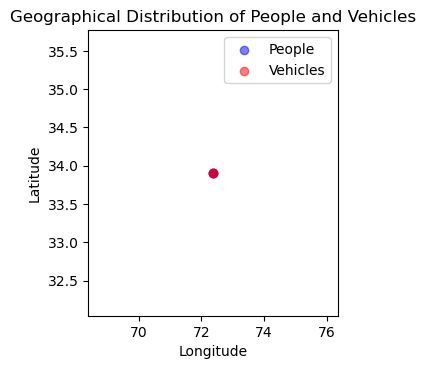

In [1]:
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QDialog
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import mysql.connector
from PyQt5.QtCore import Qt

class AnalyticsWindow(QDialog):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Analytics Dashboard")
        self.setGeometry(0, 0, 1000, 800)
        
        # Enable maximize and minimize buttons
        self.setWindowFlags(self.windowFlags() | Qt.WindowMaximizeButtonHint | Qt.WindowMinimizeButtonHint)
        
        # Set up the main layout
        main_layout = QVBoxLayout()
        
        # Inner layouts for organizing charts
        first_inner_layout = QHBoxLayout()
        second_inner_layout = QHBoxLayout()
        
        # Fetch data from the database
        people_data = self.fetch_people_data()
        vehicle_data = self.fetch_vehicle_data()
        
        # Add visualizations to the layout
        first_inner_layout.addWidget(self.create_people_line_chart(people_data), stretch=1)
        second_inner_layout.addWidget(self.create_vehicle_bar_chart(vehicle_data), stretch=1)
        second_inner_layout.addWidget(self.create_vehicle_pie_chart(people_data, vehicle_data), stretch=1)
        second_inner_layout.addWidget(self.create_location_scatter_plot(people_data, vehicle_data), stretch=1)
        
        # Add the inner layouts to the main layout
        main_layout.addLayout(first_inner_layout)
        main_layout.addLayout(second_inner_layout)
        
        # Set the main layout for the dialog
        self.setLayout(main_layout)

    def fetch_people_data(self):
        # Connect to your database and fetch people data
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="viz_optilytics"
        )
        query = "SELECT people_count, timestamp, loc_lat, loc_lon FROM people"
        people_data = pd.read_sql(query, conn)
        conn.close()
        return people_data

    def fetch_vehicle_data(self):
        # Connect to your database and fetch vehicle data
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="viz_optilytics"
        )
        query = "SELECT color, vehicle_type, timestamp, loc_lat, loc_lon FROM vehicles"
        vehicle_data = pd.read_sql(query, conn)
        conn.close()
        return vehicle_data

    def create_people_line_chart(self, data):
        # Create a line chart for people detection over time
        figure = plt.figure()
        canvas = FigureCanvas(figure)
        
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data_grouped = data.groupby(data['timestamp'].dt.strftime('%H:%M'))['people_count'].sum()
        
        ax = figure.add_subplot(111)
        ax.plot(data_grouped.index, data_grouped.values, marker='o', color='b')
        ax.set_title("People Detection Over Time")
        ax.set_xlabel("Date")
        ax.set_ylabel("People Count")
        
        return canvas

    def create_vehicle_bar_chart(self, data):
        # Create a bar chart for vehicle types
        figure = plt.figure()
        canvas = FigureCanvas(figure)

        # Group by vehicle type and count occurrences
        vehicle_counts = data['vehicle_type'].value_counts()

        ax = figure.add_subplot(111)
        vehicle_counts.plot(kind='barh', color='skyblue', ax=ax)

        # Set chart title and labels
        ax.set_title("Most Detected Vehicle Types")
        ax.set_xlabel("Count")
        ax.set_ylabel("Vehicle Type")
        return canvas

    def create_vehicle_pie_chart(self, people_data, vehicle_data):
        # Ensure the timestamp columns are in datetime format
        people_data['timestamp'] = pd.to_datetime(people_data['timestamp'])
        vehicle_data['timestamp'] = pd.to_datetime(vehicle_data['timestamp'])

        # Define 3-hour intervals and group detections by these intervals
        people_data['time_interval'] = (people_data['timestamp'].dt.hour // 3) * 3
        vehicle_data['time_interval'] = (vehicle_data['timestamp'].dt.hour // 3) * 3

        # Get the count of detections in each 3-hour interval
        people_counts_by_interval = people_data.groupby('time_interval').size()
        vehicle_counts_by_interval = vehicle_data.groupby('time_interval').size()

        # Create a figure and canvas for the bar chart with adjusted size
        figure = plt.figure(figsize=(7, 5))
        canvas = FigureCanvas(figure)
        ax = figure.add_subplot(111)

        # Plot the data as side-by-side bar charts
        people_counts_by_interval.plot(kind='bar', color='skyblue', width=0.4, position=1, ax=ax, label='People')
        vehicle_counts_by_interval.plot(kind='bar', color='lightcoral', width=0.4, position=0, ax=ax, label='Vehicles')

        # Set chart title and labels with adjusted font size
        ax.set_title("Detections by Time of Day (3-Hour Intervals)", fontsize=14)
        ax.set_xlabel("Time Interval", fontsize=12)
        ax.set_ylabel("Number of Detections", fontsize=12)

        # Define labels for each 3-hour interval
        interval_labels = [f"{i}:00-{i+3}:00" for i in range(0, 24, 3)]
        ax.set_xticks(range(0, 8))
        ax.set_xticklabels(interval_labels, rotation=45, fontsize=10)
        ax.legend()

        return canvas

    def create_location_scatter_plot(self, people_data, vehicle_data):
        # Create a scatter plot for locations of people and vehicles
        figure = plt.figure()
        canvas = FigureCanvas(figure)
        
        ax = figure.add_subplot(111)
        ax.scatter(people_data['loc_lon'], people_data['loc_lat'], color='b', label='People', alpha=0.5)
        ax.scatter(vehicle_data['loc_lon'], vehicle_data['loc_lat'], color='r', label='Vehicles', alpha=0.5)
        
        ax.set_title("Geographical Distribution of People and Vehicles")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        
        return canvas


if __name__ == "__main__":
    app = QApplication(sys.argv)
    main_window = AnalyticsWindow()
    main_window.show()
    sys.exit(app.exec_())
